# <span style="color:red"> Lecture 8
---

### Abstract
In this lecture, we want to implement the variational principle in Quantum Mechanics, which states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound.

The task is to variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space, starting from an approximate trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

which, clearly, depends on the two variational parameters $\sigma$ and $\mu$.

In order to find the best parameters $\sigma_{best}$ and $\mu_{best}$, we will implement a Search Annealing algorithm, which will explore the parameters space trying to minimize the value of $\left\langle H_T \right\rangle$. After some hand-tuning of the algorithm parameters (such as $T_{init}$, the initial temperature, and $dT$, the temperature step), we can finally start the search. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def psiT(x, mu, sigma):
    Norm = 2. * np.sqrt(np.pi*sigma*sigma) * (1. + np.exp(-(mu/sigma)**2.))
    xplus = (x+mu)/sigma
    xminus = (x-mu)/sigma
    return 1./Norm * (np.exp(-xplus*xplus/2.) + np.exp(-xminus*xminus/2.))**2

def Vpot(x):
    return (x**2 - 2.5)*x**2

def spectrum():
    hbar = 1
    m = 1
    a = 10
    N = 1000 # number of iterations

    # Step sizes
    x = np.linspace(-a/2, a/2, N)
    dx = x[1] - x[0] # the step size
    V = Vpot(x)

    # The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

    CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
    # np.diag(np.array,k) construct a "diagonal" matrix using the np.array
    # The default is k=0. Use k>0 for diagonals above the main diagonal, 
    # and k<0 for diagonals below the main diagonal

    # Hamiltonian matrix
    H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

    # Compute eigenvectors and their eigenvalues
    E,psi = np.linalg.eigh(H)

    # Take the transpose & normalize
    psi = np.transpose(psi)
    psi = psi/np.sqrt(dx)
    
    return E, psi

### Exercise 08.2

In [3]:
df_best_HT = pd.read_csv("../data/best_HT.dat", sep="\t")
df_HTs = pd.read_csv("../data/HTs.dat", sep="\t")
df_params = pd.read_csv("../data/params.dat", sep="\t")
df_xs = pd.read_csv("../data/xs.dat", sep="\t")

E, psi = spectrum()

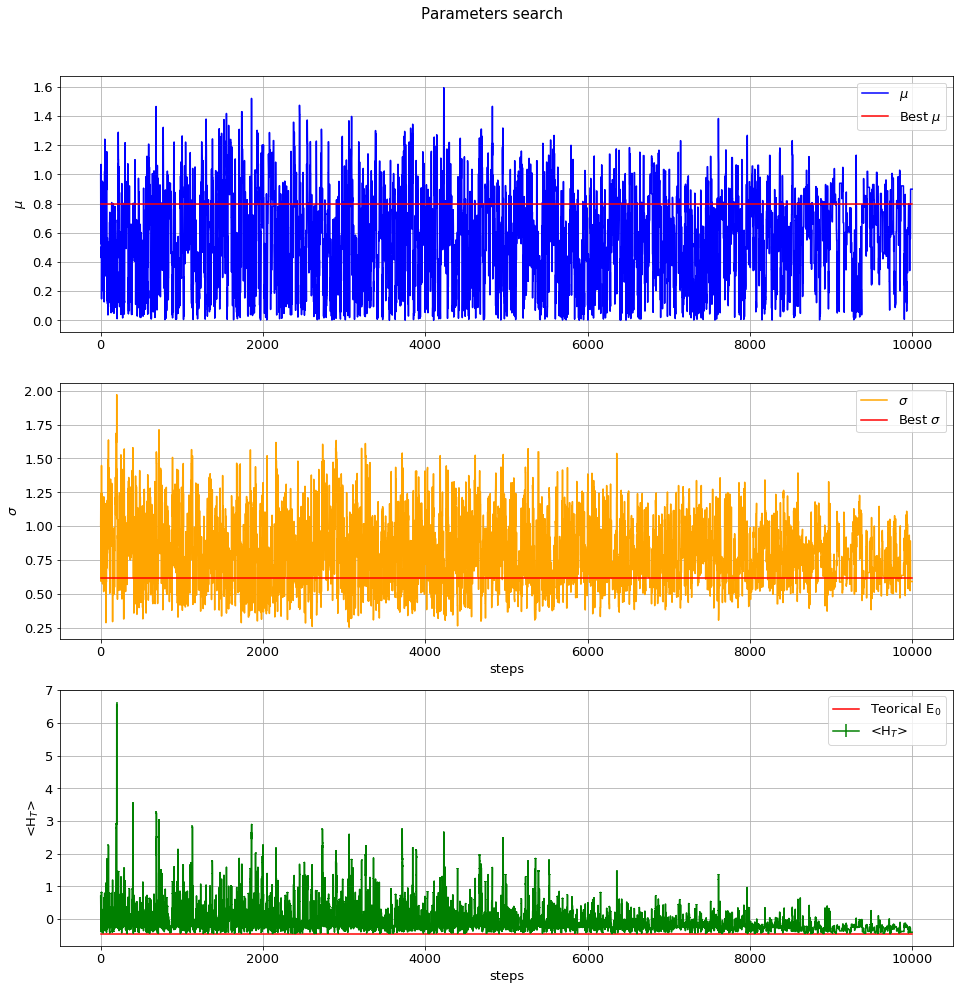

Best parameters
mu:     0.798098
sigma:  0.617231


In [4]:
mu_best = 0.798098
sigma_best = 0.617231

plt.rcParams.update({'font.size':13})
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 16), nrows=3)
fig.suptitle("Parameters search", y=0.94, size=15)

ax = ax1
ax.plot(df_params["step"], df_params["mu"], color="blue", label=r"$\mu$")
ax.plot([0, len(df_params)], [mu_best, mu_best], color="red", label="Best $\mu$")
ax.set_ylabel(r"$\mu$")
ax.grid()
ax.legend()

ax = ax2
ax.plot(df_params["step"], df_params["sigma"], color="orange", label=r"$\sigma$")
ax.plot([0, len(df_params)], [sigma_best, sigma_best], color="red", label="Best $\sigma$")
ax.set_xlabel("steps")
ax.set_ylabel(r"$\sigma$")
ax.grid()
ax.legend()

ax = ax3
ax.errorbar(df_HTs["step"], df_HTs["HT"], yerr=df_HTs["err"], color="green", label=r"<H$_T$>")
ax.plot([0, len(df_HTs)], [E[0], E[0]], color="red", label="Teorical E$_0$")
ax.set_xlabel("steps")
ax.set_ylabel(r"<H$_T$>")
ax.grid()
ax.legend()

plt.show()


print("Best parameters")
print(r"mu:    ", mu_best)
print(r"sigma: ", sigma_best)

First of all, we can see (from the last picture) the convergence of the algorithm towards the teorical value for the ground state energy. Moreover, we can observe (from the first two images) the effect of the cooling throughout the simulation, shrinking the region from which the algorithm evaluates possible couples of parameters $(\mu, \sigma)$.

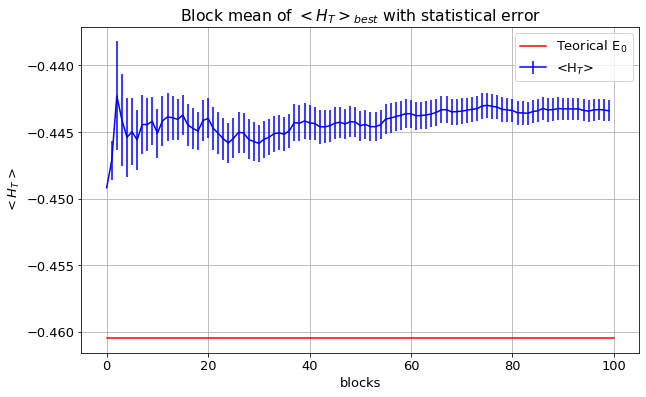

On the last block
estimate:  -0.44341 ,	error: 0.00079 ,	teorical value:  -0.46047


In [5]:
blocks = np.arange(0, len(df_best_HT))
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title(r"Block mean of $<H_T>_{best}$ with statistical error")
ax.errorbar(blocks, df_best_HT["Mean"], yerr=df_best_HT["Error"], color="blue", label=r"<H$_T$>")
ax.plot([0, len(df_best_HT)], [E[0], E[0]], color="red", label="Teorical E$_0$")
ax.set_xlabel("blocks")
ax.set_ylabel(r"$<H_T>$")
ax.grid()
ax.legend()

plt.show()


print("On the last block")
print("estimate: ", format(df_best_HT.iloc[-1, 0], '.5f'), " ± ", format(df_best_HT.iloc[-1, 1], '.5f'), ",\tteorical value: ", format(E[0], '.5f'))

Once the optimal parameters have been extracted, we can then compute the mean energy of state represented by the best trial function. We can observe that the evaluation of the ground state energy is not compatible with the numerical obtained one. This is to be expected as the variational method used is only able to give an approximation of such state.

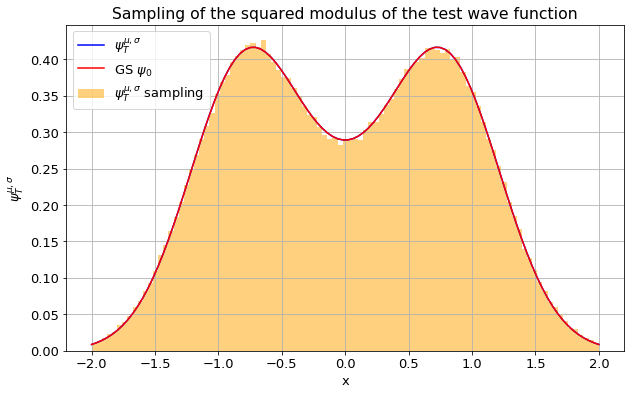

In [6]:
bins = np.linspace(-2, 2, 100)
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Sampling of the squared modulus of the test wave function")
ax.hist(df_xs["x"], bins, density=True, color="orange", alpha=0.5, label="$\psi_T^{\mu, \sigma}$ sampling")
ax.plot(bins, psiT(bins, mu_best, sigma_best), color="blue", label=r"$\psi_T^{\mu, \sigma}$")
ax.plot(bins, psiT(bins, mu_best, sigma_best), color="red", label=r"GS $\psi_0$")
ax.set_xlabel("x")
ax.set_ylabel(r"$\psi_T^{\mu, \sigma}$")
ax.grid()
ax.legend();

Lastly, even though, as we have seen, $\left\langle H_T \right\rangle _{best}$ was not compatible with the actual $E_0$ ground state energy, the SA algorithm search provides a good qualitative approximation of the actual ground state wave function, as it can be seen in the above plot. 